In [1]:
import numpy as np
import math 
import random
import matplotlib.pyplot as plt
%matplotlib inline
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F


import gym

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
env = gym.make('CartPole-v0')
env.seed(101)
np.random.seed(101)
print(device)
print(env.action_space)
print(env.observation_space)

cuda:0
Discrete(2)
Box(4,)


In [3]:
class Agent(nn.Module):
    def __init__(self,env,h_size = 32,a_size = 2):
        super(Agent,self).__init__()
        self.s_size = env.observation_space.shape[0]
        self.a_size = a_size
        self.h_size = h_size
        self.env = env
        
        self.fc1 = nn.Linear(self.s_size,self.h_size)
        self.fc2 = nn.Linear(self.h_size,self.a_size)
    
    def set_weight(self,weights):
        fc1_end = (self.s_size*self.h_size) + self.h_size
        fc1_W = torch.from_numpy(weights[:self.s_size*self.h_size].reshape(self.s_size,self.h_size))
        fc1_b = torch.from_numpy(weights[self.s_size*self.h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end + self.h_size*self.a_size].reshape(self.h_size,self.a_size))
        fc2_b = torch.from_numpy(weights[fc1_end + self.h_size*self.a_size:])
        
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        return (self.s_size + 1)*self.h_size + (self.h_size + 1)*self.a_size
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x
    
    def act(self,state):
        
        x = self.forward(state)
        #ind = np.random.choice(ind,p = x) for stochastic
        ind = np.argmax(x.cpu().detach().numpy()) #for deterministic
        return ind
    
    def evaluate(self,weight,t_max = 5000,gamma = 1.0):
        self.set_weight(weight)
        state = self.env.reset()
        total = 0.0 
        for i in range(t_max):
            state = torch.from_numpy(state).float().to(device)
            action = self.act(state)
            state,reward,done,_ = self.env.step(action)
            total += reward*math.pow(gamma,i)
            if done:
                break
        return total
    
agent = Agent(env).to(device)
        

/home/vj_rahil/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode:0	 Average Score : 69.00
Episode:10	 Average Score : 171.55
Episode:20	 Average Score : 181.33
Episode:30	 Average Score : 178.71
Episode:40	 Average Score : 182.78
Episode:50	 Average Score : 186.10
Episode:60	 Average Score : 188.38
Episode:70	 Average Score : 190.01
Episode:80	 Average Score : 191.25
Episode:90	 Average Score : 192.21
Episode:100	 Average Score : 190.49
Episode:110	 Average Score : 192.31
Episode:120	 Average Score : 192.86
RL environment solved at episode : 24	 Average Score : 195.54


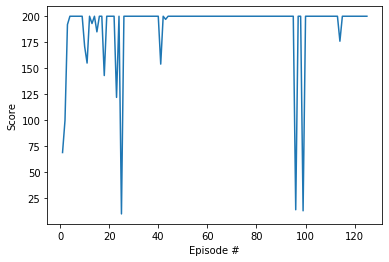

In [4]:
def SteepestHillClimbing(num_episodes = 1000,max_t = 5000,pop_size = 100,n_elite = 1,print_every = 10,noise_scale = 1e-2,gamma = 1.0):
    
    scores = []
    scores_deque = deque(maxlen = 100)
    best_weights = 1e-4*np.random.randn(agent.get_weights_dim())
    R = -np.Inf
    for i_episode in range(num_episodes):
        pop_weights = [best_weights + noise_scale*(np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        pop_rewards = np.array([agent.evaluate(weight,max_t,gamma) for weight in pop_weights])
        elite_index = pop_rewards.argsort()[-1]
        
        if pop_rewards[elite_index] >= R:
            R = pop_rewards[elite_index]
            best_weights = pop_weights[elite_index]
            noise_scale = max(1e-3,noise_scale/2)
        
        if pop_rewards[elite_index] < R:
            noise_scale = min(2,noise_scale*2)
        
        reward = agent.evaluate(best_weights)
        scores_deque.append(reward)
        scores.append(reward)
        torch.save(agent.state_dict(),'checkpoint1.pth')
        
        if i_episode%print_every == 0:
            print('Episode:{}\t Average Score : {:.2f}'.format(i_episode,np.mean(scores_deque)))
        if np.mean(np.mean(scores_deque) >= 195.0):
            print('RL environment solved at episode : {}\t Average Score : {:.2f}'.format(i_episode - 100,np.mean(scores_deque)))
            break
    return scores

scores = SteepestHillClimbing()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [5]:
agent.load_state_dict(torch.load('checkpoint1.pth'))
env = gym.make('CartPole-v0')
state = env.reset()
#img = plt.imshow(env.render(mode='rgb_array'))
for t in range(200):
    state = torch.from_numpy(state).float().to(device)
    action = agent.act(state)
    env.render()
    #display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()

/home/vj_rahil/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
